## 0. Import packages

In [1]:
import pandas as pd
import gzip
import math
from tqdm import tqdm
from itertools import chain, combinations
from Association import Association
from math import sqrt
tqdm.pandas() #for progres_apply etc.

## 1. Load data from previous step

In [2]:
import pickle
train_df = pickle.load(open("pickle_dumps/train_df.p", "rb"))
tests_df = pickle.load(open("pickle_dumps/test_df.p", "rb"))

article_train_df = pickle.load(open("pickle_dumps/article_train_df.p", "rb"))
article_test_df = pickle.load(open("pickle_dumps/article_test_df.p", "rb"))

In [3]:
train_df

,user_id,item_id
1943,1943,"[19, 21, 9, 1209, 1210, 1211, 744, 279, 280, 7..."
1011,1011,"[280, 1, 4, 6, 7, 19, 138, 20, 21, 22, 23, 25,..."
1815,1815,"[19, 21, 9, 1, 4, 6, 7, 10, 280, 1143, 281, 12..."
224,224,"[8, 20, 1021, 1022, 1023, 9, 280, 40, 27, 30, ..."
276,276,"[8, 19, 21, 9, 20, 280, 1143, 40, 27, 1081, 10..."
...,...,...
117,117,"[9, 8, 20, 1021, 1022, 1023, 1668, 1669, 280, ..."
941,941,"[6, 9, 20, 21, 22, 23, 280, 25, 1081, 1082, 13..."
2773,2773,"[8, 2, 6, 280, 1, 4, 7, 19, 138, 20, 21, 22, 2..."
1559,1559,"[280, 2541, 2352, 70, 83, 97, 104, 110, 65, 11..."


If we plot a disrtibution of the length per user, we see that most data leans towards a length of 100 items

190.6936936936937


(array([124., 100.,  89.,  77.,  67.,  61.,  50.,  40.,  37.,  34.,  33.,
         25.,  26.,  21.,  19.,  20.,  13.,  12.,  12.,  13.,  13.,   5.,
         12.,   7.,   9.,   5.,   7.,   5.,   9.,   8.,   4.,   1.,   5.,
          1.,   4.,   2.,   3.,   3.,   2.,   2.,   2.,   2.,   3.,   0.,
          2.,   2.,   2.,   3.,   2.,   1.]),
 array([101.  , 110.88, 120.76, 130.64, 140.52, 150.4 , 160.28, 170.16,
        180.04, 189.92, 199.8 , 209.68, 219.56, 229.44, 239.32, 249.2 ,
        259.08, 268.96, 278.84, 288.72, 298.6 , 308.48, 318.36, 328.24,
        338.12, 348.  , 357.88, 367.76, 377.64, 387.52, 397.4 , 407.28,
        417.16, 427.04, 436.92, 446.8 , 456.68, 466.56, 476.44, 486.32,
        496.2 , 506.08, 515.96, 525.84, 535.72, 545.6 , 555.48, 565.36,
        575.24, 585.12, 595.  ]),
 <BarContainer object of 50 artists>)

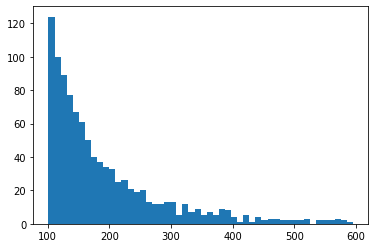

In [4]:
import matplotlib.pyplot as plt
x = [len(i) for i in train_df["item_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [5]:
article_train_df

,item_id,user_id
3,1209,"[1943, 1815, 2206, 656, 1631, 284, 664, 1283, ..."
4,1210,"[1943, 1815, 2206, 656, 1631, 284, 664, 1283, ..."
5,1211,"[1943, 1815, 2206, 656, 1631, 284, 664, 1283, ..."
6,744,"[1943, 1011, 276, 1786, 523, 101, 386, 1998, 1..."
7,279,"[1943, 2560, 284, 1597, 785, 1091, 692, 11, 31..."
...,...,...
6373,3925,"[400, 412, 1478]"
6374,3934,"[3169, 948]"
6383,6653,"[1452, 1478]"
6384,5493,"[1452, 941]"


The transposed dataframe that is used for building user association rules has only a few items most of the time. this is not that important because of the way user associations are build.

31.508467822275353


(array([2.442e+03, 7.400e+02, 4.260e+02, 2.600e+02, 1.510e+02, 1.330e+02,
        1.110e+02, 8.000e+01, 8.000e+01, 6.000e+01, 5.700e+01, 5.300e+01,
        3.500e+01, 4.200e+01, 2.400e+01, 3.600e+01, 1.900e+01, 1.400e+01,
        1.700e+01, 1.700e+01, 1.900e+01, 2.100e+01, 1.300e+01, 1.500e+01,
        4.000e+00, 8.000e+00, 1.000e+01, 1.200e+01, 1.100e+01, 1.300e+01,
        1.000e+01, 1.000e+01, 1.000e+00, 6.000e+00, 9.000e+00, 4.000e+00,
        3.000e+00, 8.000e+00, 6.000e+00, 8.000e+00, 5.000e+00, 5.000e+00,
        1.000e+00, 0.000e+00, 5.000e+00, 9.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00]),
 array([  2.  ,   9.92,  17.84,  25.76,  33.68,  41.6 ,  49.52,  57.44,
         65.36,  73.28,  81.2 ,  89.12,  97.04, 104.96, 112.88, 120.8 ,
        128.72, 136.64, 144.56, 152.48, 160.4 , 168.32, 176.24, 184.16,
        192.08, 200.  , 207.92, 215.84, 223.76, 231.68, 239.6 , 247.52,
        255.44, 263.36, 271.28, 279.2 , 287.12, 295.04, 302.96, 310.88,
        318.8 , 

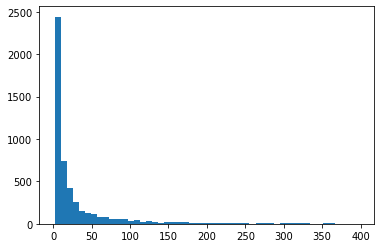

In [6]:
x = [len(i) for i in article_train_df["user_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [7]:
tests_df

,user_id,item_id
1587,1587,"[9, 0, 2, 3, 5, 277, 278, 280, 19, 20, 21, 22,..."
1113,1113,"[280, 16, 2648, 1209, 1210, 1211, 24, 94, 1627..."
563,563,"[280, 1377, 63, 64, 110, 140, 154, 157, 423, 1..."
2265,2265,"[9, 1021, 1022, 1023, 280, 40, 26, 27, 29, 108..."
554,554,"[8, 280, 24, 1085, 1, 4, 6, 7, 19, 138, 20, 21..."
...,...,...
403,403,"[19, 21, 280, 336, 315, 43, 46, 47, 1619, 1620..."
1453,1453,"[280, 1092, 486, 1321, 1322, 1619, 97, 48, 60,..."
2071,2071,"[14, 280, 5502, 3962, 305, 24, 1323, 1035, 132..."
1805,1805,"[14, 2647, 357, 4842, 336, 12, 425, 426, 427, ..."


In [8]:
data = train_df.set_index("user_id").to_dict()["item_id"]
article_data = article_train_df.set_index("item_id").to_dict()["user_id"]

## 2. Functions or building association rules

In [9]:
def eclat(prefix, minsup, items, start=True):
    """
    Basic eclat implementation for finding frequent itemsets
    """
    frequents = []
    while items:
        i,itids = items.pop()
        isupp = len(itids)
        if isupp >= minsup:
            frequents.append((frozenset(prefix + [i]), isupp))
            suffix = [] 
            for j, ojtids in items:
                jtids = set(itids) & set(ojtids)
                if len(jtids) >= minsup:
                    suffix.append((j,jtids))
            frequents.extend(eclat(prefix+[i], minsup, sorted(suffix, key=lambda item: len(item[1]), reverse=True), False))
    return frequents

In [10]:
def subsets(itemset, include_empty_set=False):
    """ List all strict subsets of an itemset without the empty set or with the empty set if include_empty_set=True
        subsets({1,2,3}) --> [{1}, {2}, {3}, {1, 2}, {1, 3}, {2, 3}]
    """
    s = list(itemset)
    if include_empty_set:
        return map(set, chain.from_iterable(combinations(s, r) for r in range(0, len(s) + 1)))
    return map(set, chain.from_iterable(combinations(s, r) for r in range(1, len(s))))

In [11]:
def deriveRules(itemsets, minconf, test_users):
    """ Returns all rules with conf >= minconf that can be derived from the itemsets.
        Return: list of association rules in the format: [(antecedent, consequent, supp, conf), ...]
    """
    search_items = dict(itemsets)
    rules = []
    for item_set, supp in tqdm(itemsets):
        if len(item_set) > 1: # itemsets with one frequent item are unable to generate a rule
            for subset in subsets(item_set):  # for each subset generate a rule
                antecedent = frozenset(subset)
                consequent = item_set - subset
                if len(consequent)== 1: # only keep rules with one item in the consequent
                    conf = supp / search_items[antecedent]
                    if conf >= minconf: # assure confidence of the rule is high enough
                        # if test_users are passed, only generate rules with one of the test users in the consequent
                        if test_users:
                            if list(consequent)[0] in test_users:
                                rules.append(Association(antecedent, consequent, conf, supp))
                        else:
                            rules.append(Association(antecedent, consequent, conf, supp))
                        

    return rules

In [12]:
def genRules(min_conf, minsup, data, test_users = None):
    print("---Mining frequent itemsets---")
    frequent_itemsets = eclat([], minsup, sorted(data.items(), key=lambda item: len(item[1]), reverse=True))
    print(f"{len(frequent_itemsets)} frequent itemsets")
    c = 0
    for f in frequent_itemsets:
        if len(f[0]) == 1:
            c += 1
    print(f"{c} frequent itemsets of length 1")
    print("---Generating rules---")
    return deriveRules(frequent_itemsets, min_conf, test_users)

## 3. Build association rules

### Article association rules
Build rules of the form:
`Item1 and Item2 -> Item3`

In [13]:
%%time

print(len(data))

# Build the article association rules with a minimum support of 50 and minimum confidence of 0.85
article_assos_rules = genRules(0.85, 50, data)

999
---Mining frequent itemsets---
4513425 frequent itemsets
999 frequent itemsets of length 1
---Generating rules---


100%|██████████████████████████████| 4513425/4513425 [02:14<00:00, 33552.62it/s]


CPU times: user 4min 9s, sys: 3.57 s, total: 4min 13s
Wall time: 4min 12s


In [14]:
len(article_assos_rules)

6994418

In [15]:
%%time

# print number of rules with item 3 in the lhs
counter = 0
for r in article_assos_rules:
    if 3 in r.left:
        counter += 1
counter

CPU times: user 1.13 s, sys: 0 ns, total: 1.13 s
Wall time: 1.13 s


90549

In [16]:
# print number of rules with a support greater than 150
for r in article_assos_rules:
    if r.s > 150:
        print(r)

Conf: 0.87	Supp: 158.00	 {1328, 1276, 1839} => {1576}


### User association rules
Build rules of the form: `User1 and User2 -> User3`

This builds rules that represent the relation and similarity between users.

In [17]:
%%time
import copy
# user_assos_rules = genRules(0.0, 20, article_data)
print(len(article_data))
test_users = tests_df["user_id"].tolist()

rules_split = []

# build the datasets for training. We always add one part of the test set to the trainingset in order to create 4 different
# sets of user association rules
for i in range(4):
    print(f"Mining rules for split {i}")
    tmp = copy.deepcopy(article_data)
    for _, article in article_test_df.iterrows():
        try: # add the training split to the training data
            if article["item_id"] in tmp:
                tmp[article["item_id"]] += article["test_split"][i][0]
            else:
                tmp[article["item_id"]] = article["test_split"][i][0]
#                 print(tmp[article["item_id"]])
#                 break
        except: # if the item has not enough user interactions to create 4 splits, add all user items
            if article["item_id"] in tmp:
                tmp[article["item_id"]] += article["user_id"]
            else:
                tmp[article["item_id"]] = article["user_id"]
    
    # Build the user association rules with a minimum support of 40 and minimum confidence of 0.0
    r = genRules(0.0,40,tmp, test_users)
    rules_split.append(r)

5019
Mining rules for split 0
---Mining frequent itemsets---
1844646 frequent itemsets
1097 frequent itemsets of length 1
---Generating rules---


100%|███████████████████████████████| 1844646/1844646 [03:12<00:00, 9580.59it/s]


Mining rules for split 1
---Mining frequent itemsets---
1693575 frequent itemsets
1102 frequent itemsets of length 1
---Generating rules---


100%|██████████████████████████████| 1693575/1693575 [02:44<00:00, 10270.33it/s]


Mining rules for split 2
---Mining frequent itemsets---
1582067 frequent itemsets
1105 frequent itemsets of length 1
---Generating rules---


100%|███████████████████████████████| 1582067/1582067 [02:58<00:00, 8874.38it/s]


Mining rules for split 3
---Mining frequent itemsets---
1595787 frequent itemsets
1109 frequent itemsets of length 1
---Generating rules---


100%|███████████████████████████████| 1595787/1595787 [02:43<00:00, 9757.51it/s]

CPU times: user 13min 55s, sys: 4.07 s, total: 13min 59s
Wall time: 13min 57s


In [18]:
# print numebr of generated rules per split
for i in range(4):
    print(len(rules_split[i]))

279173
243077
245652
249061


See for how much test users we were able to create association rules and how many

In [19]:
corr = {}
test_users = tests_df["user_id"].tolist()
for user in test_users:
    for r in rules_split[3]:
        if user in list(r.right):
            if user in corr:
                corr[user] += 1
            else:
                corr[user] = 1

In [20]:
print(len(test_users))
print(len(corr))
print(corr)

101
32
{1113: 839, 563: 1709, 554: 62, 359: 109764, 498: 511, 690: 381, 2876: 8, 1344: 166, 2320: 9, 2174: 19, 1915: 5, 221: 162, 551: 4963, 1521: 5, 1261: 9, 106: 415, 1089: 721, 396: 4, 1322: 20231, 1081: 9265, 746: 257, 1595: 1, 648: 5, 1399: 329, 194: 92634, 262: 2787, 1900: 21, 2353: 12, 1249: 3, 1246: 231, 255: 483, 1805: 3050}


## 4. Normalize support / confidence to better use it later

In [22]:
minc = 1
maxc = 0

mins = 9999999999999
maxs = -9999999999999
for a in article_assos_rules:
    if a.c < minc:
        minc = a.c
    if a.c > maxc:
        maxc = a.c
    
    if a.s < mins:
        mins = a.s
    if a.s > maxs:
        maxs = a.s
            
for a in article_assos_rules:
    a.c = (a.c - minc) / (maxc - minc)
    a.s = (a.s - mins) / (maxs - mins)
    # temp score that's just lhs + weighted average of c, s
    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))

article_assos_rules = sorted(article_assos_rules, key = lambda x: x.score, reverse=True)
for i in article_assos_rules[:100]:
    print(i)

Conf: 1.00	Supp: 52.00	 {512, 481, 736, 4, 167, 1576, 1328, 785, 1555} => {2970}
Conf: 1.00	Supp: 52.00	 {512, 481, 736, 4, 1576, 1328, 785, 1555, 2970} => {167}
Conf: 1.00	Supp: 52.00	 {512, 481, 4, 167, 1576, 1328, 785, 1555, 2970} => {736}
Conf: 1.00	Supp: 50.00	 {736, 4, 167, 1576, 780, 750, 1839, 212, 1597} => {1328}
Conf: 1.00	Supp: 50.00	 {736, 167, 1576, 780, 750, 1839, 1328, 212, 1597} => {4}
Conf: 1.00	Supp: 50.00	 {512, 481, 736, 1412, 4, 167, 1328, 785, 1555} => {2970}
Conf: 1.00	Supp: 50.00	 {512, 481, 736, 1412, 4, 167, 1328, 785, 2970} => {1555}
Conf: 1.00	Supp: 50.00	 {512, 481, 1412, 4, 167, 1328, 785, 1555, 2970} => {736}
Conf: 1.00	Supp: 50.00	 {512, 481, 736, 167, 1576, 1328, 785, 2258, 1555} => {2970}
Conf: 1.00	Supp: 50.00	 {512, 481, 736, 1576, 1328, 785, 2258, 1555, 2970} => {167}
Conf: 1.00	Supp: 50.00	 {512, 481, 167, 1576, 1328, 785, 2258, 1555, 2970} => {736}
Conf: 1.00	Supp: 50.00	 {512, 481, 736, 4, 167, 1328, 785, 2258, 1555} => {2970}
Conf: 1.00	Supp: 50

## 5. Store the association rules as pickle file for further use

In [23]:
import pickle
pickle.dump(article_assos_rules, open("pickle_dumps/article_rules.p", "wb"))
pickle.dump(rules_split, open("pickle_dumps/user_rules.p", "wb"))